In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
#from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from IPython.display import clear_output
from typing import NamedTuple
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()


try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

pd.set_option('max_row', None)
pd.set_option('max_column', None)


class SinglePeriod:
    def __init__(
        self, 
        data,  
        preds, 
        budget, 
        init_budget,
        share_budget,
        sampler, 
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):
    
        self.df = data
        self.preds = preds
        self.budget = budget
        self.share_budget = share_budget
        self.init_budget = init_budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.stocks = self.df.columns.tolist()
        
        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        # if sampler_args:
        #     self.sampler_args = json.loads(str(sampler_args))
        # else:
        #     self.sampler_args = {}

        #self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.sampler = sampler
        self.solution = {}
        self.precision = 2

        self.list_dates = self.df.index.values

    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        print(f'idx: {idx}')
        print(f'self.df.loc: {self.df.loc[idx,:]}')
        self.max_num_shares = (self.share_budget/self.df.loc[idx,:]).astype(int)
        print(f'max_num_shares: {self.max_num_shares}')
        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}
        print(f'x: {x}')
        
        #print(f'self.df')
        #display(self.df.head())
        #print(f'self.df.index.values: {self.df.index.values}')
        #print(f'self.list_dates: {self.list_dates}')
        self.position = np.where(self.list_dates == idx)[0][0]
        print(f'self.position: {self.position}')
        #self.position2 = np.where(self.list_dates == idx)[0]
        #print(f'self.position 2: {self.position2}')
        self.initial_position = self.list_dates[self.position-5]
        print(f'self.initial_position: {self.initial_position}')
        #print('self.df')
        #display(self.df)
        self.price = self.df.loc[idx, :]
        print(f'sum price: {self.price.sum()}')
        print(f'price: {self.price}')
        #print(self.price)
        self.pct_returns = self.df.pct_change()
        self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        #self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        print(f'sum daily returns: {self.daily_returns.stack().sum()}')
        self.avg_daily_returns = self.daily_returns.rolling(window=1).mean().loc[idx,:]
        #self.avg_daily_returns = self.preds
        print(f'avg daily returns: {self.avg_daily_returns.sum()}')
        # print('avg daily returns 2')
        # display(self.avg_daily_returns2.head())
        self.covariance_matrix = self.daily_returns.cov()
        self.correlation_matrix = self.daily_returns.corr()
        #print('cov matrix')
        #display(self.covariance_matrix.head())
        print(f'covariance_matrix sum: {self.covariance_matrix.stack().sum()}')
        #print('corr matrix')
        #display(self.correlation_matrix.head())
        print(f'correlation_matrix sum: {self.correlation_matrix.stack().sum()}')

        
        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]       
        #print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]
        print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            print(f'self.init_holdings: {self.init_holdings}')
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0

            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')
            print(f'upper bound = budget: {self.budget}')
            print(f'init_budget: {self.init_budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')
            print(f'lhs: {lhs}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')

           
        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            print('cqm debugging')
            print(f'risk: {type(risk)}')
            print(f'returns: {returns}')
            print(f'objective: {self.alpha*risk - returns}')

            cqm.set_objective(self.alpha*risk - returns)
            #cqm.set_objective(-1*returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm

    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:        
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        sum_solution = 0
        for s1 in solution:
            #print(f's1: {s1}, {solution[s1]}, price: {self.price[s1]}')
            sum_solution += solution[s1]
            #print(f'covariance matrix: {self.covariance_matrix[s1].sum()}')

        print(f'MMM price: {self.price["MMM"]}, solution: {solution["MMM"]}')
        print(f'sum price: {sum(self.price)}')
        print(f'sum solution: {sum_solution}')

        variance = 0.0
        for s1, s2 in product(solution, solution):
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        for stock in solution:
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self, 
                data, 
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):
    
        self.save_path = save_path
        self.df = data
        self.stocks = self.df.columns.values.tolist()
        self.stocks = sorted(self.stocks)

        
        self.sampler_args = sampler_args
        self.budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type
        
        initial_gspc = self.baseline.query('Date==@dates[0]').values.tolist()[0][0]
        #print('initial baseline')
        #display(self.baseline)
        #print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        self.init_budget = budget
        #print('final baseline')
        #display(self.baseline)
        #print('initial data')
        #display(self.df.head())

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}

        print('iniital_holdings')
        print(self.init_holdings)
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = sorted(self.stocks)
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}
        # self.sample_set = {}
        # self.sampler_args = sampler_args
        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}

        self.solution = {}
        
    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """
        
        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []
        
        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'returns', 'value'])
        #row = []
        

        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')
            df_train = self.df.loc[:idx, :]
            #print('df train')
            #display(df_train.head())
            self.preds = predict_returns(df_train)
            self.price = self.df.loc[idx, :]
            baseline_current = self.baseline.loc[idx, :]
            # single_period = SinglePeriod(data=self.df, 
            #                              preds=self.preds.pct_change().iloc[-1,:], 
            #                              budget=self.budget, 
            #                              init_budget = self.init_budget,
            #                              sampler_args=self.sampler_args, 
            #                              dates=self.dates,
            #                              model_type=self.model_type,
            #                              alpha=self.alpha,
            #                              verbose=self.verbose,
            #                              t_cost=self.t_cost,
            #                              label=self.label,
            #                              init_holdings=self.init_holdings)

            if first_purchase:
                print(f'first purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                # single_period = SinglePeriod(data=self.df, 
                #                          preds=self.preds.pct_change().iloc[-1,:], 
                #                          budget=self.budget, 
                #                          init_budget = self.init_budget,
                #                          sampler_args=self.sampler_args, 
                #                          dates=self.dates,
                #                          model_type=self.model_type,
                #                          alpha=self.alpha,
                #                          verbose=self.verbose,
                #                          t_cost=self.t_cost,
                #                          label=self.label,
                #                          init_holdings=self.init_holdings)
                initial_budget = self.budget
                self.share_budget = self.budget
                
                baseline_shares = (self.budget / baseline_current)
                #display(self.baseline)
                #self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
                #self.init_holdings = self.solution['stocks']
                #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            else:
                #self.budget = sum([self.df.iloc[-1][s]*self.solution['stocks'][s] for s in self.stocks])
                self.share_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            # Set budget to 0 to enforce that portfolio is self-financing
                if self.t_cost and not first_purchase:
                    #self.budget = 1
                    self.budget = 0.0
                    #self.budget = self.init_budget
                print(f'new purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                
                
                # if self.t_cost and not first_purchase:
                #     self.budget = 0
            
            single_period = SinglePeriod(data=self.df, 
                                            preds=self.preds.pct_change().iloc[-1,:], 
                                            budget=self.budget, 
                                            init_budget = self.init_budget,
                                            share_budget = self.share_budget,
                                            sampler=self.sampler, 
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            
            
            #print(f'budget before calculation: {self.budget}, initial_budget: {initial_budget}')
            print(f'init_holdings before calculation: {self.init_holdings}')
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'final budget: {sum([self.price[s]*self.solution["stocks"][s] for s in self.stocks])}')
            print(f'init_holdings after calculation: {self.init_holdings}')

            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            print(f'sum shares: {sum([self.solution["stocks"][s] for s in self.stocks])}')
            returns = self.solution['return']
            variance = self.solution['risk']

            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'returns': returns, 'value': value}])])
            
            first_purchase = False

            #clear_output(wait=True)
            initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / initial_budget - 1
            display(self.agg_results)
            
            fig = plt.figure(figsize=(10.708,8.2))
            sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            plt.show()
            print(f'\nRun completed.\n')

            self.output.to_pickle(self.save_path+'output.pkl')
            self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
            self.baseline.to_pickle(self.save_path+'baseline.pkl')

        return None

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    print(f'stocks: {stocks}')
    #panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    panel_data = pdr.get_data_yahoo(stocks, start=initial_date, end=dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)
    
    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    #index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    index_df = pdr.get_data_yahoo(baseline, start=dates[0], end=dates[1])
    df_baseline = index_df['Adj Close'].to_frame().rename(columns={'Adj Close': '^GSPC'})
    #df_baseline = pd.DataFrame(index=index_df.index, columns=['Adj Close'])
    #for i in baseline:
    #    df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:  
                if b == '0':
                    inverse_s += '1'       
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)
            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            if total <= budget and total > 0.9 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8)) 
    ax.hist(score_report) 
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0   
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]
    
        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8)) 
            ax[0].hist(scores) 
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000,
            'bin_size': '',
            'gamma': '',
            'alpha': 1.0E-6,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.001,
            'n_iter': 10000,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'RunTest',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}
locals().update(cfg)

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
stocks = first_table['Symbol'].values.tolist()
stocks = ['MMM', 'GOOG', 'AAP']
#print(f'stocks: {stocks}')
stocks = sorted(stocks)
print(f'stocks: {stocks}')

df, df_baseline = load_data(initial_date, dates, stocks, baseline)



stocks: ['AAP', 'GOOG', 'MMM']

Loading live data from the web from Yahoo! finance from 2021-01-01 to 2021-07-01...
reader initial date: 2021-01-01
reader final_date: 2021-07-01
stocks: ['AAP', 'GOOG', 'MMM']
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


initial df


,AAP,GOOG,MMM
Date,,,
2021-01-04,149.533585,86.412003,159.806458
2021-01-05,149.372025,87.045998,159.536819
2021-01-06,158.001541,86.764503,161.963608
2021-01-07,159.351089,89.362503,157.807388
2021-01-08,161.622482,90.360497,154.924927


iniital_holdings
{'AAP': 0, 'GOOG': 0, 'MMM': 0}
num_days: 22
idx: 2021-06-01 00:00:00
first purchase budget: 1000, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 0, 'MMM': 0}
idx: 2021-06-01 00:00:00
self.df.loc: AAP     185.246979
GOOG    121.490501
MMM     191.896164
Name: 2021-06-01 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-01 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 102
self.initial_position: 2021-05-24T00:00:00.000000000
sum price: 498.6336441040039
price: AAP     185.246979
GOOG    121.490501
MMM     191.896164
Name: 2021-06-01 00:00:00, dtype: float64
sum daily returns: 0.04187874183709073
avg daily returns: 0.034287337832854536
covariance_matrix sum: 0.0003168

,idx,variance,returns,value,value_norm
0,2021-06-01,37.4,11.75,997.267288,0.0


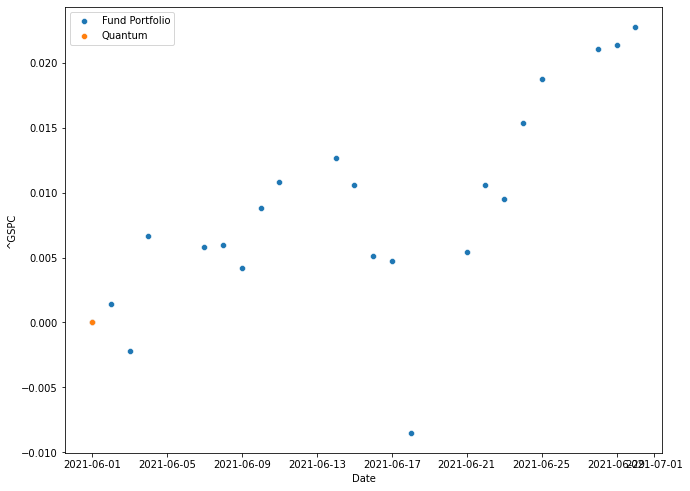


Run completed.

idx: 2021-06-02 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 2, 'GOOG': 2, 'MMM': 2}
idx: 2021-06-02 00:00:00
self.df.loc: AAP     182.087387
GOOG    121.064003
MMM     191.981140
Name: 2021-06-02 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-02 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 103
self.initial_position: 2021-05-25T00:00:00.000000000
sum price: 495.13253021240234
price: AAP     182.087387
GOOG    121.064003
MMM     191.981140
Name: 2021-06-02 00:00:00, dtype: float64
sum daily returns: 0.01379150309316135
avg daily returns: -0.020123829284017236
covariance_matrix sum: 0.0004372589469874187
correlation_matrix sum: 2.9678364

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007


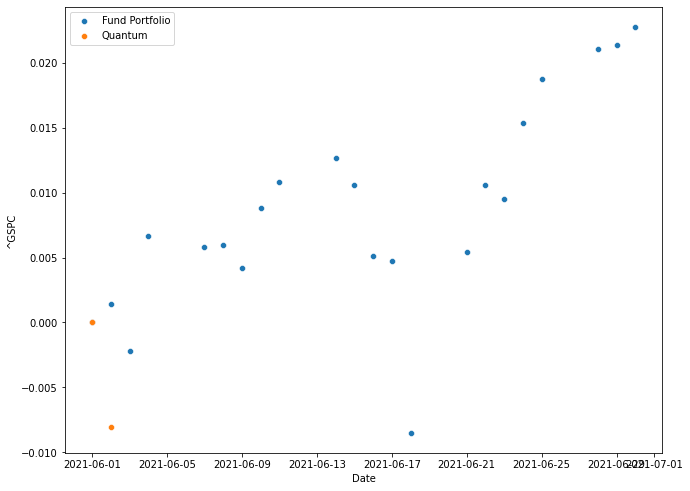


Run completed.

idx: 2021-06-03 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 5, 'MMM': 2}
idx: 2021-06-03 00:00:00
self.df.loc: AAP     181.906540
GOOG    120.230499
MMM     192.339996
Name: 2021-06-03 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-03 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 104
self.initial_position: 2021-05-26T00:00:00.000000000
sum price: 494.47703552246094
price: AAP     181.906540
GOOG    120.230499
MMM     192.339996
Name: 2021-06-03 00:00:00, dtype: float64
sum daily returns: 0.025127049228015896
avg daily returns: -0.006008781348589953
covariance_matrix sum: 0.0003696094636312423
correlation_matrix sum: 2.232518

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466


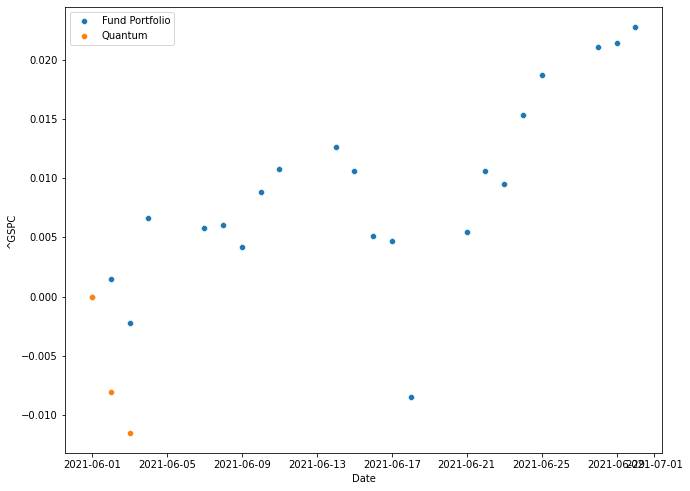


Run completed.

idx: 2021-06-04 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 5, 'MMM': 2}
idx: 2021-06-04 00:00:00
self.df.loc: AAP     183.448303
GOOG    122.587997
MMM     194.587601
Name: 2021-06-04 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-04 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 105
self.initial_position: 2021-05-27T00:00:00.000000000
sum price: 500.6239013671875
price: AAP     183.448303
GOOG    122.587997
MMM     194.587601
Name: 2021-06-04 00:00:00, dtype: float64
sum daily returns: 0.050015643241940966
avg daily returns: 0.039769313275515916
covariance_matrix sum: 0.0005793020926307454
correlation_matrix sum: 4.74440855

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861


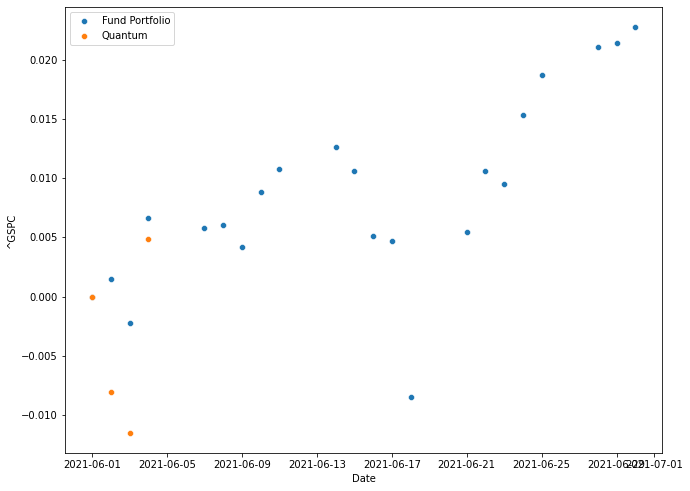


Run completed.

idx: 2021-06-07 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 5, 'MMM': 2}
idx: 2021-06-07 00:00:00
self.df.loc: AAP     183.686218
GOOG    123.304497
MMM     192.396652
Name: 2021-06-07 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-07 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 106
self.initial_position: 2021-05-28T00:00:00.000000000
sum price: 499.38736724853516
price: AAP     183.686218
GOOG    123.304497
MMM     192.396652
Name: 2021-06-07 00:00:00, dtype: float64
sum daily returns: 0.05236728549247438
avg daily returns: -0.004117764873830532
covariance_matrix sum: 0.0005662970437356484
correlation_matrix sum: 5.2242335

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060


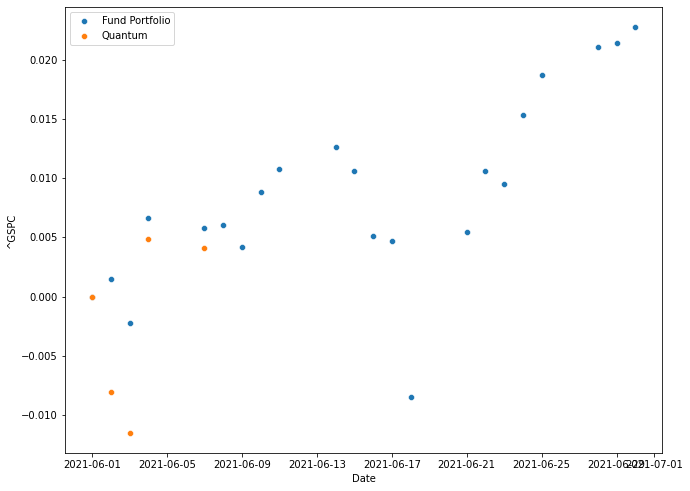


Run completed.

idx: 2021-06-08 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 5, 'MMM': 2}
idx: 2021-06-08 00:00:00
self.df.loc: AAP     188.311432
GOOG    124.142502
MMM     192.264450
Name: 2021-06-08 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-08 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 107
self.initial_position: 2021-06-01T00:00:00.000000000
sum price: 504.7183837890625
price: AAP     188.311432
GOOG    124.142502
MMM     192.264450
Name: 2021-06-08 00:00:00, dtype: float64
sum daily returns: 0.0750953378461996
avg daily returns: 0.03128906224426686
covariance_matrix sum: 0.0006508740430120946
correlation_matrix sum: 5.01863726827

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275


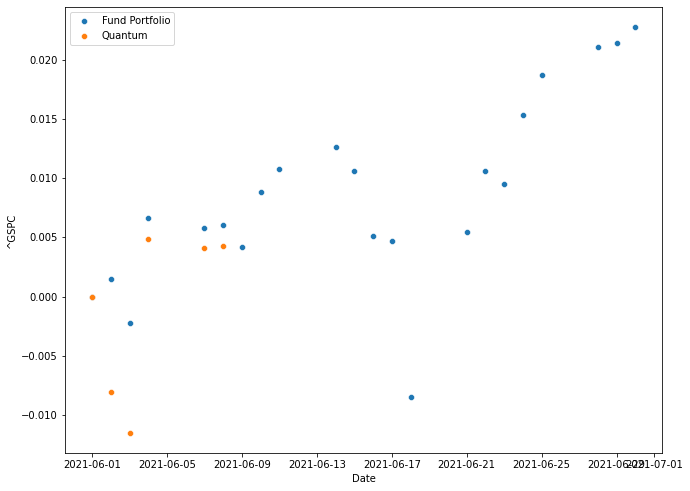


Run completed.

idx: 2021-06-09 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 4, 'GOOG': 2, 'MMM': 0}
idx: 2021-06-09 00:00:00
self.df.loc: AAP     187.512039
GOOG    124.570000
MMM     191.461761
Name: 2021-06-09 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-09 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 108
self.initial_position: 2021-06-02T00:00:00.000000000
sum price: 503.5438003540039
price: AAP     187.512039
GOOG    124.570000
MMM     191.461761
Name: 2021-06-09 00:00:00, dtype: float64
sum daily returns: 0.03583162985524935
avg daily returns: -0.004976370158095711
covariance_matrix sum: 0.0005658827234743541
correlation_matrix sum: 5.14892454

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709


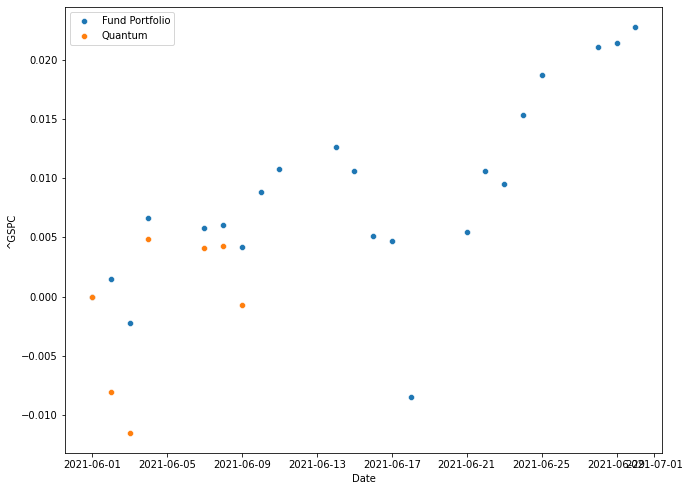


Run completed.

idx: 2021-06-10 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-10 00:00:00
self.df.loc: AAP     186.389023
GOOG    126.080002
MMM     191.830063
Name: 2021-06-10 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-10 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 109
self.initial_position: 2021-06-03T00:00:00.000000000
sum price: 504.29908752441406
price: AAP     186.389023
GOOG    126.080002
MMM     191.830063
Name: 2021-06-10 00:00:00, dtype: float64
sum daily returns: 0.06401176791117391
avg daily returns: 0.008056308771907328
covariance_matrix sum: 0.000404083153568549
correlation_matrix sum: 4.685127682

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404


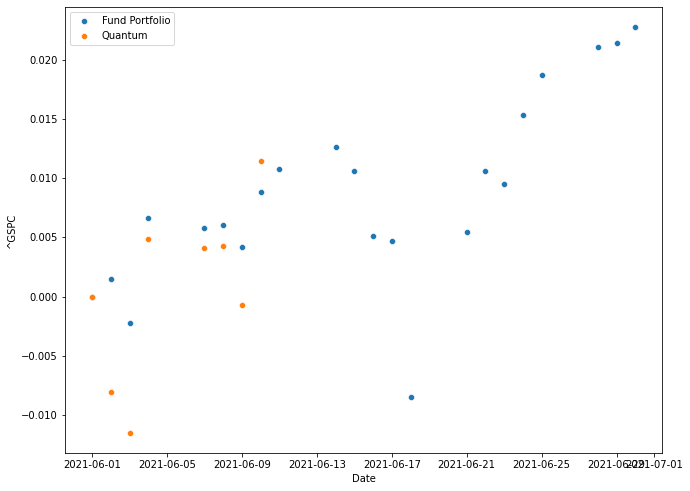


Run completed.

idx: 2021-06-11 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-11 00:00:00
self.df.loc: AAP     189.805588
GOOG    125.696503
MMM     191.527832
Name: 2021-06-11 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-11 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 110
self.initial_position: 2021-06-04T00:00:00.000000000
sum price: 507.02992248535156
price: AAP     189.805588
GOOG    125.696503
MMM     191.527832
Name: 2021-06-11 00:00:00, dtype: float64
sum daily returns: 0.08373361367354049
avg daily returns: 0.013713064413776621
covariance_matrix sum: 0.00033734463577560285
correlation_matrix sum: 4.2114091

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327


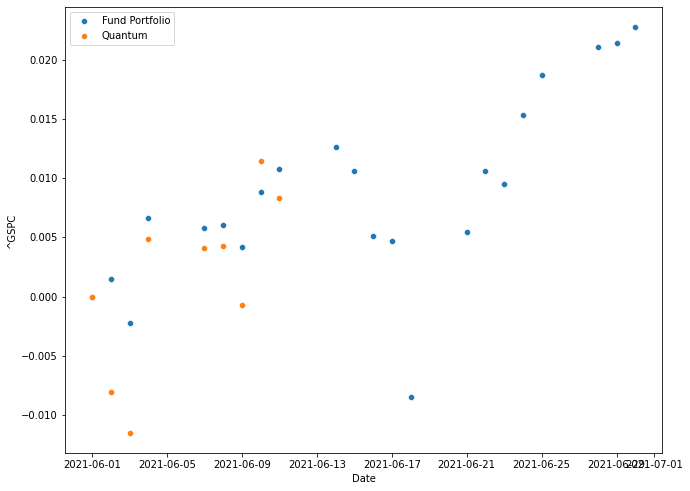


Run completed.

idx: 2021-06-14 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-14 00:00:00
self.df.loc: AAP     188.996658
GOOG    126.351997
MMM     190.158508
Name: 2021-06-14 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-14 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 111
self.initial_position: 2021-06-07T00:00:00.000000000
sum price: 505.50716400146484
price: AAP     188.996658
GOOG    126.351997
MMM     190.158508
Name: 2021-06-14 00:00:00, dtype: float64
sum daily returns: 0.03776783966132813
avg daily returns: -0.006196460736696441
covariance_matrix sum: 0.00021486781676485948
correlation_matrix sum: 3.097907

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


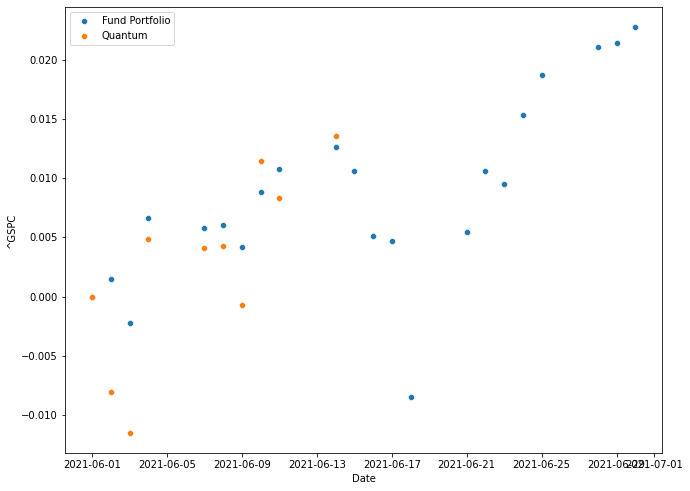


Run completed.

idx: 2021-06-15 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-15 00:00:00
self.df.loc: AAP     190.966660
GOOG    126.032997
MMM     189.450256
Name: 2021-06-15 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-15 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 112
self.initial_position: 2021-06-08T00:00:00.000000000
sum price: 506.44991302490234
price: AAP     190.966660
GOOG    126.032997
MMM     189.450256
Name: 2021-06-15 00:00:00, dtype: float64
sum daily returns: 0.04605984615684011
avg daily returns: 0.0041742416216814515
covariance_matrix sum: 0.00019179148736659827
correlation_matrix sum: 3.473621

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


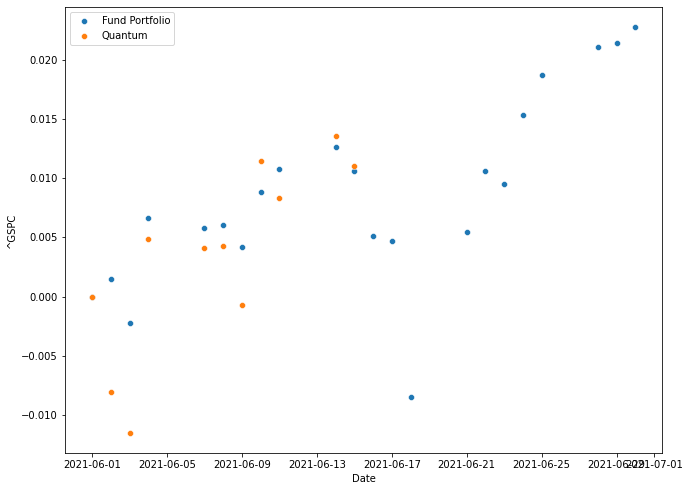


Run completed.

idx: 2021-06-16 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-16 00:00:00
self.df.loc: AAP     187.407333
GOOG    125.696503
MMM     185.956085
Name: 2021-06-16 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-16 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 113
self.initial_position: 2021-06-09T00:00:00.000000000
sum price: 499.05992126464844
price: AAP     187.407333
GOOG    125.696503
MMM     185.956085
Name: 2021-06-16 00:00:00, dtype: float64
sum daily returns: -0.024981316093993233
avg daily returns: -0.03975210000656648
covariance_matrix sum: 0.00036195107093468207
correlation_matrix sum: 4.57173

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


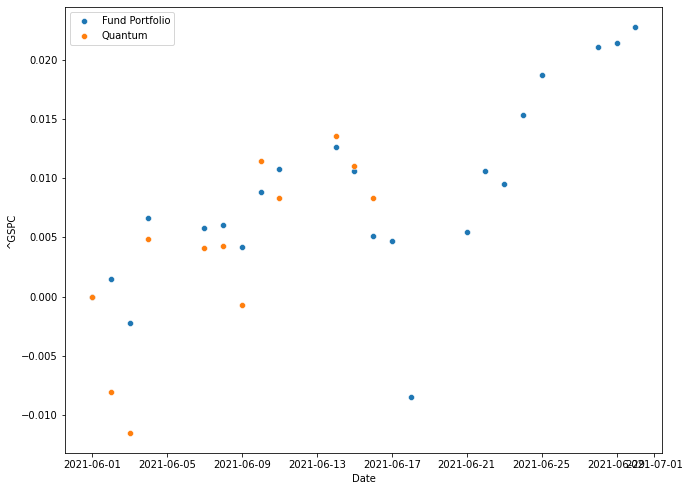


Run completed.

idx: 2021-06-17 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-17 00:00:00
self.df.loc: AAP     185.943817
GOOG    126.371002
MMM     184.284515
Name: 2021-06-17 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-17 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 114
self.initial_position: 2021-06-10T00:00:00.000000000
sum price: 496.5993347167969
price: AAP     185.943817
GOOG    126.371002
MMM     184.284515
Name: 2021-06-17 00:00:00, dtype: float64
sum daily returns: -0.03143718614902924
avg daily returns: -0.011432240213131717
covariance_matrix sum: 0.00037099642489673044
correlation_matrix sum: 4.446452

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


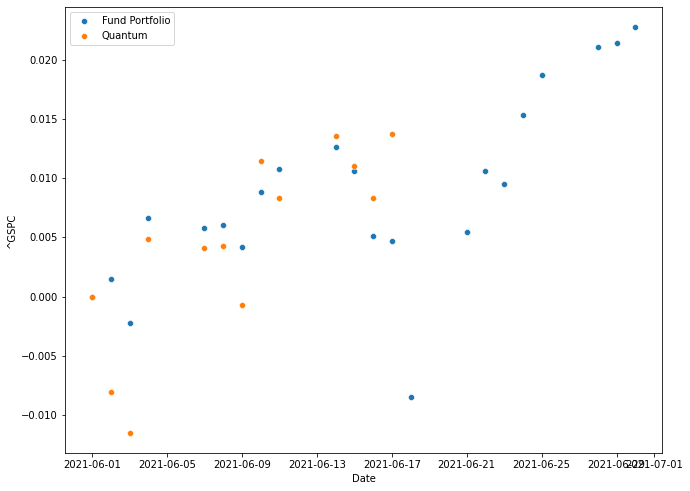


Run completed.

idx: 2021-06-18 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-18 00:00:00
self.df.loc: AAP     184.929871
GOOG    125.567497
MMM     180.941467
Name: 2021-06-18 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-18 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 115
self.initial_position: 2021-06-11T00:00:00.000000000
sum price: 491.43883514404297
price: AAP     184.929871
GOOG    125.567497
MMM     180.941467
Name: 2021-06-18 00:00:00, dtype: float64
sum daily returns: -0.06944545815117575
avg daily returns: -0.029951963230239187
covariance_matrix sum: 0.0004096271234649221
correlation_matrix sum: 4.905764

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


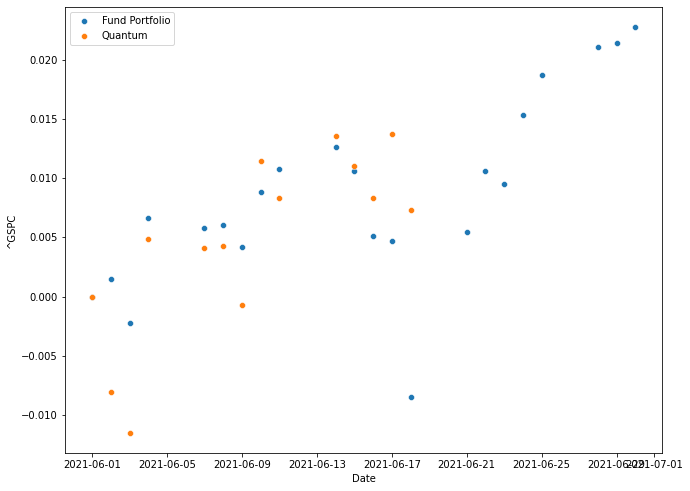


Run completed.

idx: 2021-06-21 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-21 00:00:00
self.df.loc: AAP     189.846527
GOOG    126.455002
MMM     184.350632
Name: 2021-06-21 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-21 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 116
self.initial_position: 2021-06-14T00:00:00.000000000
sum price: 500.65216064453125
price: AAP     189.846527
GOOG    126.455002
MMM     184.350632
Name: 2021-06-21 00:00:00, dtype: float64
sum daily returns: -0.03066271872169668
avg daily returns: 0.052495803843255695
covariance_matrix sum: 0.0010525950251855877
correlation_matrix sum: 7.0450849

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


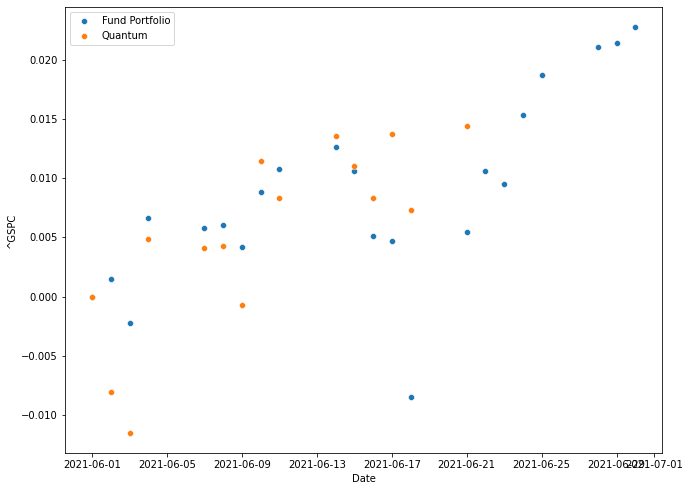


Run completed.

idx: 2021-06-22 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 0, 'GOOG': 8, 'MMM': 0}
idx: 2021-06-22 00:00:00
self.df.loc: AAP     191.348328
GOOG    126.999496
MMM     184.284515
Name: 2021-06-22 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-22 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 117
self.initial_position: 2021-06-15T00:00:00.000000000
sum price: 502.63233947753906
price: AAP     191.348328
GOOG    126.999496
MMM     184.284515
Name: 2021-06-22 00:00:00, dtype: float64
sum daily returns: -0.012608462261552988
avg daily returns: 0.01185779572344725
covariance_matrix sum: 0.0010990782305639337
correlation_matrix sum: 7.4249216

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


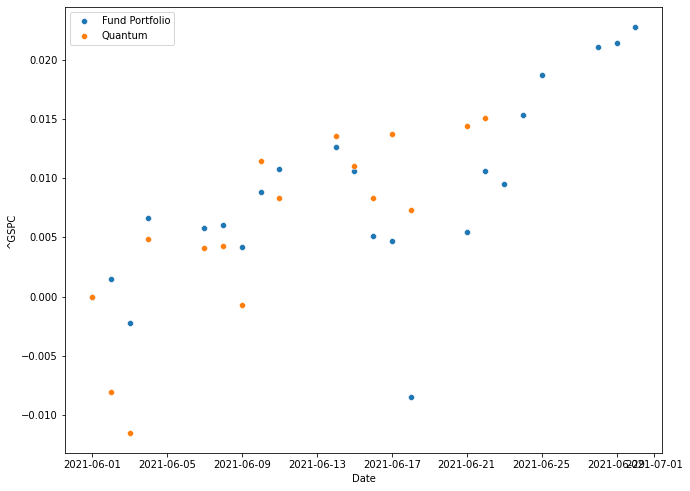


Run completed.

idx: 2021-06-23 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 3, 'GOOG': 2, 'MMM': 1}
idx: 2021-06-23 00:00:00
self.df.loc: AAP     191.989212
GOOG    126.461502
MMM     181.659180
Name: 2021-06-23 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    7
MMM     5
Name: 2021-06-23 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 118
self.initial_position: 2021-06-16T00:00:00.000000000
sum price: 500.1098937988281
price: AAP     191.989212
GOOG    126.461502
MMM     181.659180
Name: 2021-06-23 00:00:00, dtype: float64
sum daily returns: -0.03191568970114267
avg daily returns: -0.015132985817908229
covariance_matrix sum: 0.00111274022627708
correlation_matrix sum: 7.559175500

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


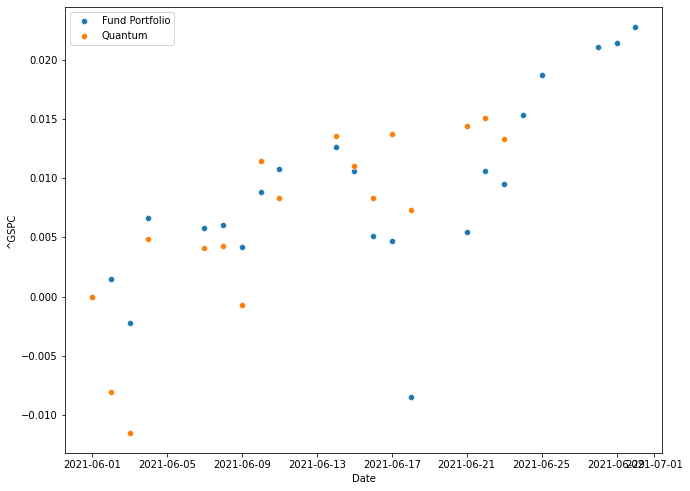


Run completed.

idx: 2021-06-24 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 3, 'GOOG': 2, 'MMM': 1}
idx: 2021-06-24 00:00:00
self.df.loc: AAP     192.228363
GOOG    127.281998
MMM     182.509109
Name: 2021-06-24 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    7
MMM     5
Name: 2021-06-24 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 119
self.initial_position: 2021-06-17T00:00:00.000000000
sum price: 502.01947021484375
price: AAP     192.228363
GOOG    127.281998
MMM     182.509109
Name: 2021-06-24 00:00:00, dtype: float64
sum daily returns: 0.020248869763574318
avg daily returns: 0.012412459458150504
covariance_matrix sum: 0.0008477946493306278
correlation_matrix sum: 7.1617093

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


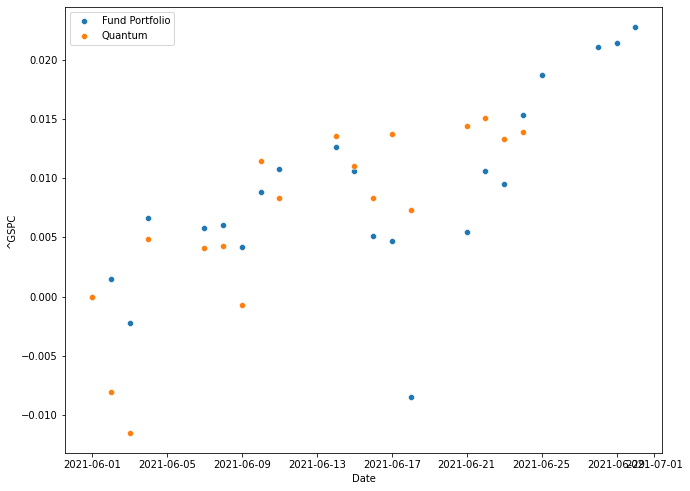


Run completed.

idx: 2021-06-25 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 1, 'GOOG': 5, 'MMM': 1}
idx: 2021-06-25 00:00:00
self.df.loc: AAP     195.547577
GOOG    126.995003
MMM     183.916229
Name: 2021-06-25 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    7
MMM     5
Name: 2021-06-25 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 120
self.initial_position: 2021-06-18T00:00:00.000000000
sum price: 506.4588088989258
price: AAP     195.547577
GOOG    126.995003
MMM     183.916229
Name: 2021-06-25 00:00:00, dtype: float64
sum daily returns: 0.054403209362074545
avg daily returns: 0.02272209938536851
covariance_matrix sum: 0.000839924437428474
correlation_matrix sum: 7.3127685497

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


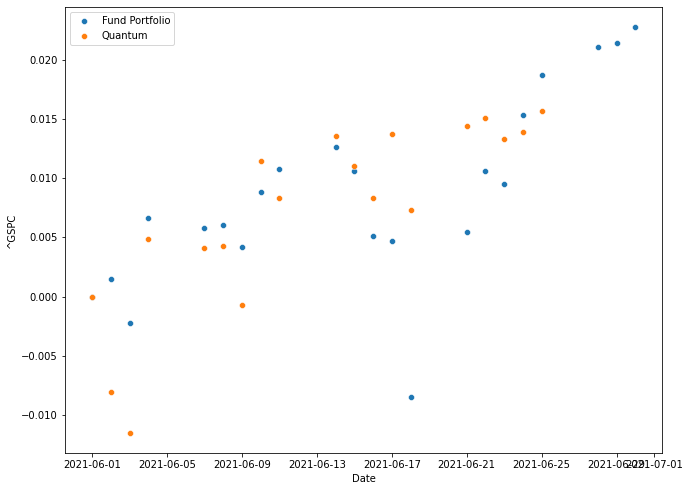


Run completed.

idx: 2021-06-28 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 2, 'GOOG': 2, 'MMM': 2}
idx: 2021-06-28 00:00:00
self.df.loc: AAP     195.624084
GOOG    126.819504
MMM     185.568863
Name: 2021-06-28 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-28 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 121
self.initial_position: 2021-06-21T00:00:00.000000000
sum price: 508.012451171875
price: AAP     195.624084
GOOG    126.819504
MMM     185.568863
Name: 2021-06-28 00:00:00, dtype: float64
sum daily returns: 0.09235028019557479
avg daily returns: 0.007995107603261054
covariance_matrix sum: 0.00048765593083331655
correlation_matrix sum: 5.973435079

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


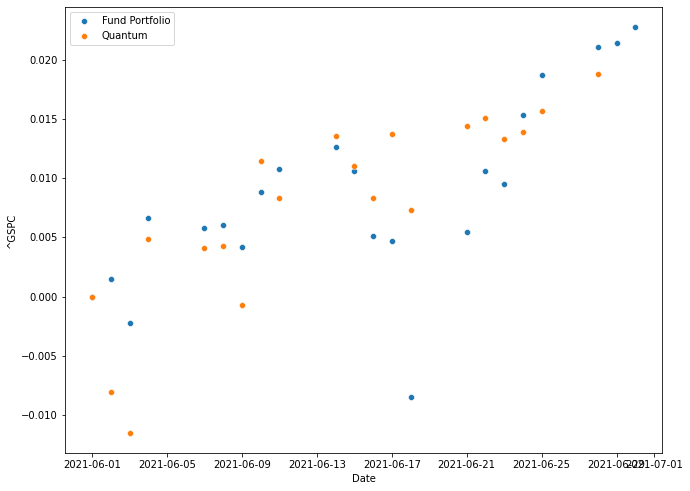


Run completed.

idx: 2021-06-29 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 2, 'GOOG': 2, 'MMM': 2}
idx: 2021-06-29 00:00:00
self.df.loc: AAP     196.379776
GOOG    126.018501
MMM     185.125046
Name: 2021-06-29 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-29 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 122
self.initial_position: 2021-06-22T00:00:00.000000000
sum price: 507.52332305908203
price: AAP     196.379776
GOOG    126.018501
MMM     185.125046
Name: 2021-06-29 00:00:00, dtype: float64
sum daily returns: 0.0350097140248099
avg daily returns: -0.004844762327509189
covariance_matrix sum: 0.00018461819687548453
correlation_matrix sum: 3.9390580

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


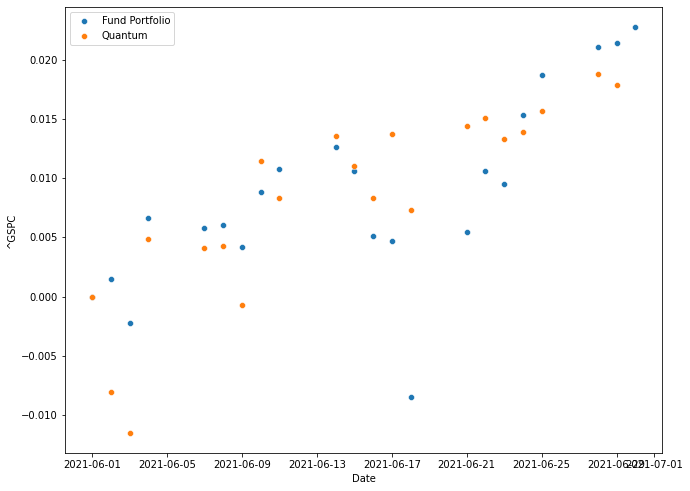


Run completed.

idx: 2021-06-30 00:00:00
new purchase budget: 0.0, initial_budget: 1000
init_holdings before calculation: {'AAP': 2, 'GOOG': 2, 'MMM': 2}
idx: 2021-06-30 00:00:00
self.df.loc: AAP     196.226730
GOOG    125.316002
MMM     187.580383
Name: 2021-06-30 00:00:00, dtype: float64
max_num_shares: AAP     5
GOOG    8
MMM     5
Name: 2021-06-30 00:00:00, dtype: int64
x: {'AAP': QuadraticModel({'AAP': 1.0}, {}, 0.0, {'AAP': 'INTEGER'}, dtype='float64'), 'GOOG': QuadraticModel({'GOOG': 1.0}, {}, 0.0, {'GOOG': 'INTEGER'}, dtype='float64'), 'MMM': QuadraticModel({'MMM': 1.0}, {}, 0.0, {'MMM': 'INTEGER'}, dtype='float64')}
self.position: 123
self.initial_position: 2021-06-23T00:00:00.000000000
sum price: 509.1231155395508
price: AAP     196.226730
GOOG    125.316002
MMM     187.580383
Name: 2021-06-30 00:00:00, dtype: float64
sum daily returns: 0.030061139626365696
avg daily returns: 0.006909221325003045
covariance_matrix sum: 0.000176777799537363
correlation_matrix sum: 3.233195977

,idx,variance,returns,value,value_norm
0,2021-06-01,37.40,11.75,997.267288,0.000000
0,2021-06-02,16.75,-1.95,989.282295,-0.008007
0,2021-06-03,19.16,-3.42,985.832489,-0.011466
0,2021-06-04,62.04,16.57,1002.115189,0.004861
0,2021-06-07,54.18,-0.73,1001.315788,0.004060
0,2021-06-08,190.17,20.65,1001.530731,0.004275
0,2021-06-09,85.36,3.43,996.559998,-0.000709
0,2021-06-10,79.72,12.23,1008.640015,0.011404
0,2021-06-11,60.42,-3.06,1005.572021,0.008327
0,2021-06-14,24.88,5.27,1010.815979,0.013586


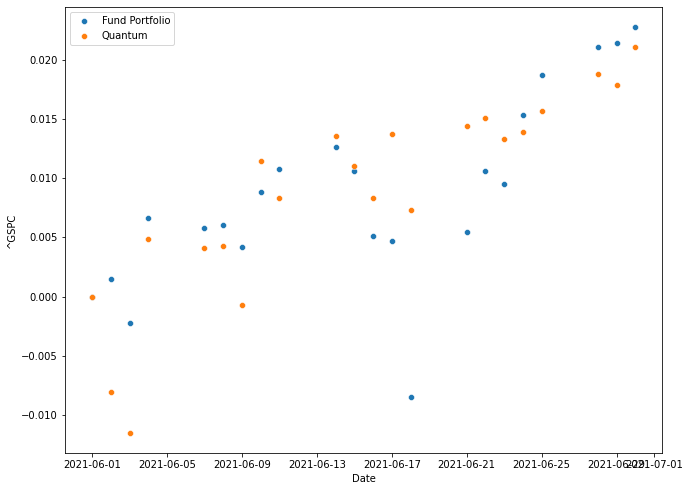


Run completed.



In [9]:
print('initial df')
display(df.head())

# if not init_holdings_path: 
#     init_holdings_df, budget = generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget)
#     init_holdings_df.to_pickle(save_path+'init_holdings.pkl')
# else:
#     init_holdings_df = pd.read_pickle(init_holdings_path)
#     prices = df.loc[dates[0], :].values.tolist()
#     #print('init holdings df')
#     #display(init_holdings_df.head())
#     #print(f'prices: {prices}')
#     pop = init_holdings_df['b'].values.tolist()
#     #print(f'pop: {pop}')
#     budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])
#     print(f'GA budget: {budget}')

# init_holdings = {}
# for idx, row in init_holdings_df.iterrows():
#     init_holdings.update({row['a']: row['b']})
init_holdings = {s:0 for s in stocks}

#print(f'init_holdings: {init_holdings}')
#print(f'new budget: {budget}')
  
# checking if the directory demo_folder 
# exist or not.
if not os.path.exists(save_path+label):
    os.makedirs(save_path+label)

my_portfolio = MultiPeriod(data=df,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=sampler_args,
                        dates=dates,
                        file_path=file_path,
                        model_type=model_type,
                        alpha=alpha,
                        verbose=verbose,
                        t_cost=t_cost,
                        label=label,
                        init_holdings=init_holdings,
                        save_path=save_path+label+'/'
                        )

my_portfolio.run(min_return=min_return, max_risk=max_risk, num=num)